# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Признаки:  
* DateCrawled — дата скачивания анкеты из базы  
* VehicleType — тип автомобильного кузова  
* RegistrationYear — год регистрации автомобиля  
* Gearbox — тип коробки передач  
* Power — мощность (л. с.)  
* Model — модель автомобиля  
* Kilometer — пробег (км)  
* RegistrationMonth — месяц регистрации автомобиля  
* FuelType — тип топлива  
* Brand — марка автомобиля  
* NotRepaired — была машина в ремонте или нет  
* DateCreated — дата создания анкеты  
* NumberOfPictures — количество фотографий автомобиля  
* PostalCode — почтовый индекс владельца анкеты (пользователя)  
* LastSeen — дата последней активности пользователя  

Целевой признак:  
* Price — цена (евро)

## Подготовка данных

### Загрузка библиотек

In [1]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
import matplotlib.pyplot as plt

### Загрузка данных

In [2]:
frame = pd.read_csv("/datasets/autos.csv")
frame.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [3]:
frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [4]:
frame.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Как видно из распределения числовых признаков, в данных есть аномалии:  
* Price — цена (евро) - минимум равен нулю, что будем считать ошибкой, также высокое значение стандартного отклонения;  
* RegistrationYear — год регистрации автомобиля - минимальное значение равно 1000, максмальное 9999;  
* Power — мощность (л. с.) - минимальное значение равно нулю, максимальное 20000;  
* RegistrationMonth — месяц регистрации автомобиля - минимальное значение равно нулю, при этом максимальное равно 12;  
* NumberOfPictures — количество фотографий автомобиля - в столбце отсутствуют значения больше нуля.

Оценим влияние числовых признаков друг на друга:

In [5]:
frame.corr()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
Price,1.000000,0.026916,0.158872,-0.333199,0.110581,NaN,0.076055
RegistrationYear,0.026916,1.000000,-0.000828,-0.053447,-0.011619,NaN,-0.003459
Power,0.158872,-0.000828,1.000000,0.024002,0.043380,NaN,0.021665
Kilometer,-0.333199,-0.053447,0.024002,1.000000,0.009571,NaN,-0.007698
RegistrationMonth,0.110581,-0.011619,0.043380,0.009571,1.000000,NaN,0.013995
NumberOfPictures,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PostalCode,0.076055,-0.003459,0.021665,-0.007698,0.013995,NaN,1.000000


Исходя из инфомации о корреляции признаков, можно сделать вывод о том, что цена автомобиля обратно пропорциональна его пробегу, при этом прямо пропорциональна его мощности. Несколько меньшее влияние на цену играет месцк регистрации автомобиля.

### Подготовка данных

#### Обработка пропусков

Оценим количество пропусков в таблице:

In [6]:
frame.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

Так как количество пропусков составляет существенную часть данных, и нет явных признаков для восстановления пропущенных значений, заполним признаки в таблице в столбцах "VehicleType", "Gearbox",  "Model", "FuelType" наиболее часто встречающимися значениями:

In [7]:
frame['VehicleType'] = frame['VehicleType'].fillna(frame['VehicleType'].mode().values[0])
frame['Gearbox'] = frame['Gearbox'].fillna(frame['Gearbox'].mode().values[0])
frame['Model'] = frame['Model'].fillna(frame['Model'].mode().values[0])
frame['FuelType'] = frame['FuelType'].fillna(frame['FuelType'].mode().values[0])

Пропуски в столбце "NotRepaired" нелогично заполнять самыми часто встречающимися значениями, поэтому заполним пропуски в нем как значение "no".

In [8]:
frame['NotRepaired'] = frame['NotRepaired'].fillna("no")

#### Обработка дубликатов

Проверим значения категорийных признаков на дубликаты (без учета регистра):

In [9]:
objects_columns = ['VehicleType','Gearbox','Model','FuelType','Brand','NotRepaired']
for column in objects_columns:
    print(column, pd.Series(frame[column].unique()).str.lower().duplicated().sum())

VehicleType 0
Gearbox 0
Model 0
FuelType 0
Brand 0
NotRepaired 0


Оценим количество полных дубликатов в таблице:

In [10]:
frame.duplicated().sum()

5

Удалим полные дубликаты из таблицы:

In [11]:
frame = frame.drop_duplicates()
frame.duplicated().sum()

0

#### Удаление столбцов

Удалим столбцы, не влияющие на стоимость автомобиля:

Такие столбцы, как "DateCrawled"(дата скачивания анкеты из базы),"DateCreated"(дата создания анкеты),"LastSeen"(дата последней активности пользователя),"NumberOfPictures"(количество фотографий автомобиля),"PostalCode"(почтовый индекс владельца анкеты) не являются важными для анализа данными, так как не могут существенно влиять на стоимость автомобиля.

In [12]:
frame_with_date = frame.copy()
frame = frame.drop(['DateCrawled','DateCreated','LastSeen','NumberOfPictures','PostalCode'],axis = 1)
frame.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
0,480,sedan,1993,manual,0,golf,150000,0,petrol,volkswagen,no
1,18300,coupe,2011,manual,190,golf,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,no
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no


#### Обработка столбца RegistrationMonth

Обработаем выбросы в столбце RegistrationMonth — месяц регистрации автомобиля:

Ранее было выявлено, что минимальное значение равно нулю, при этом максимальное равно 12.   
Оценим распределение значений для каждого месяца по убыванию:

In [13]:
frame['RegistrationMonth'].value_counts(ascending=False)

0     37352
3     34373
6     31507
4     29270
5     29153
7     27211
10    26099
12    24289
11    24186
9     23812
1     23218
8     22627
2     21267
Name: RegistrationMonth, dtype: int64

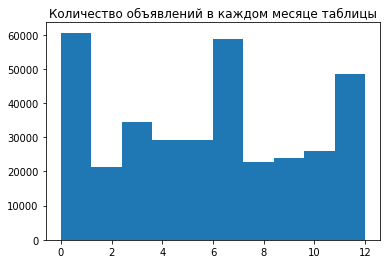

In [14]:
plt.hist(frame['RegistrationMonth'])
plt.title('Количество объявлений в каждом месяце таблицы');

Вероятно, при формировании данных произошла ошибка, ряду значений с индексом "1" было присвоено значение "0".  
Присвоим всем строкам месяца регистрации автомобиля с значением "0" значение "1".

In [15]:
frame.loc[frame['RegistrationMonth'] == 0, 'RegistrationMonth'] = 1

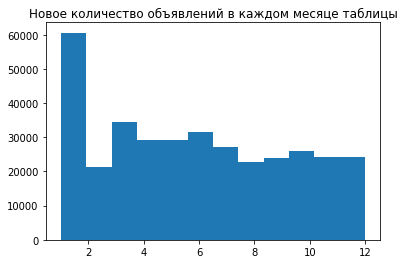

In [16]:
plt.hist(frame['RegistrationMonth'], bins=12)
plt.title('Новое количество объявлений в каждом месяце таблицы');

Подобное распределение данных может соответствовать действительности: зачастую автосалоны и частные продавцы размещают большое число объявлений в конце и начале года, когда автомобили начинают резко терять в цене за счет выпуска автомобилей в новом году.

#### Обработка столбца Power

Как видно из [открытых источников](https://avtika.ru/kak-schitaetsya-moschnost-dvigatelya-s-turbinoy/), даже у болидов "Формулы-1" на 1 литр объема двгателя при использовании турбины приходится 300 л/с.  
75% автомобилей в таблице имеют мощность в 143 лошадиные силы или меньше, так же часть автомобилей имеет мощность, равную нулю.

Построим диаграмму размаха мощности автомобилей в таблице для 3\4 данных (0-75%):

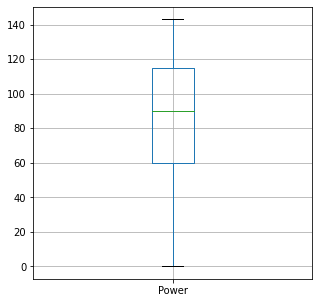

In [17]:
frame.loc[frame['Power'] <= frame['Power'].quantile(0.75)].boxplot('Power', grid=True, figsize=(5, 5));

И для оставшейся четверти данных (75-100%):

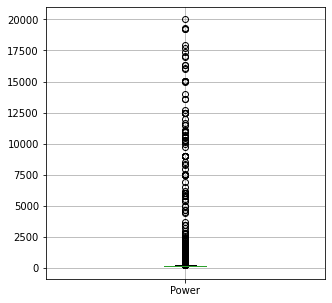

In [18]:
frame.loc[frame['Power'] > frame['Power'].quantile(0.75)].boxplot('Power', grid=True, figsize=(5, 5));

В данных наблюдается существенное количество аномальных значений мощности автомобилей.  
За нижний предел возьмем значение мощности 15 л\с ([источник](https://ru.wikipedia.org/wiki/%D0%9B%D0%BE%D1%88%D0%B0%D0%B4%D0%B8%D0%BD%D0%B0%D1%8F_%D1%81%D0%B8%D0%BB%D0%B0)), за верхний предел возьмем значение мощности 3500 л\с автомобиля БелАЗ-75600 ([источник](https://ru.wikipedia.org/wiki/%D0%91%D0%B5%D0%BB%D0%90%D0%97-75600#:~:text=%D0%94%D0%B8%D0%B7%D0%B5%D0%BB%D1%8C%D0%BD%D1%8B%D0%B9%20%D1%87%D0%B5%D1%82%D1%8B%D1%80%D1%91%D1%85%D1%82%D0%B0%D0%BA%D1%82%D0%BD%D1%8B%D0%B9%2018%2D%D1%86%D0%B8%D0%BB%D0%B8%D0%BD%D0%B4%D1%80%D0%BE%D0%B2%D1%8B%D0%B9%20V,%D1%81.)):

In [19]:
frame.loc[frame['Power'] < 15, 'Power'] = 15
frame.loc[frame['Power'] > 3500, 'Power'] = 3500

Таким образом, мы получили следующее распределение мощности автомобилей в таблице:

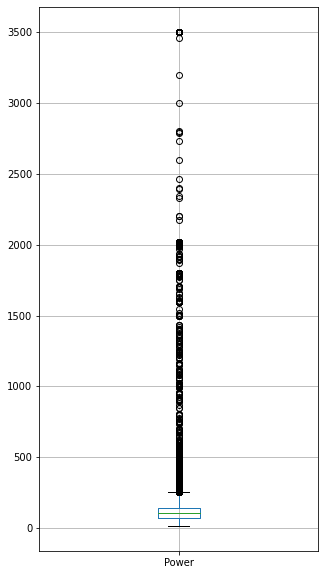

In [20]:
frame.boxplot('Power', grid=True, figsize=(5, 10));

#### Обработка столбца RegistrationYear

Ранее было выявлено, что для столбца года регистрации автомобиля минимальное значение равно 1000, а максмальное 9999.  
На данный момент год регистрации автомобиля не может быть больше 2022го, и менее 1888 года:  
[Источник](https://www.dw.com/ru/%D0%BF%D0%B5%D1%80%D0%B2%D1%8B%D0%B9-%D0%B0%D0%B2%D1%82%D0%BE%D0%BC%D0%BE%D0%B1%D0%B8%D0%BB%D1%8C-%D0%B8-%D0%B5%D0%B3%D0%BE-%D1%81%D0%BE%D0%B7%D0%B4%D0%B0%D1%82%D0%B5%D0%BB%D1%8C/a-15144268#:~:text=%D0%9F%D0%B5%D1%80%D0%B2%D1%8B%D0%B9%20%D0%B0%D0%B2%D1%82%D0%BE%D0%BC%D0%BE%D0%B1%D0%B8%D0%BB%D1%8C%2C%20%D1%81%D1%82%D0%B0%D0%B2%D1%88%D0%B8%D0%B9%20%D1%81%D0%B5%D1%80%D0%B8%D0%B9%D0%BD%D0%BE%D0%B9%20%D0%BC%D0%BE%D0%B4%D0%B5%D0%BB%D1%8C%D1%8E,%D0%BE%D1%81%D0%BD%D0%B0%D1%81%D1%82%D0%B8%D0%BB%20%D0%B1%D0%B5%D0%BD%D0%B7%D0%B8%D0%BD%D0%BE%D0%B2%D1%8B%D0%BC%20%D0%B4%D0%B2%D0%B8%D0%B3%D0%B0%D1%82%D0%B5%D0%BB%D0%B5%D0%BC%20%D0%B2%D0%BD%D1%83%D1%82%D1%80%D0%B5%D0%BD%D0%BD%D0%B5%D0%B3%D0%BE%20%D1%81%D0%B3%D0%BE%D1%80%D0%B0%D0%BD%D0%B8%D1%8F.) 

In [21]:
frame.loc[frame['RegistrationYear'] < 1888, 'RegistrationYear'] = 1888
frame.loc[frame['RegistrationYear'] > 2022, 'RegistrationYear'] = 2022

Таким образом, мы получили следующее распределение года регистрации автомобиля в таблице:

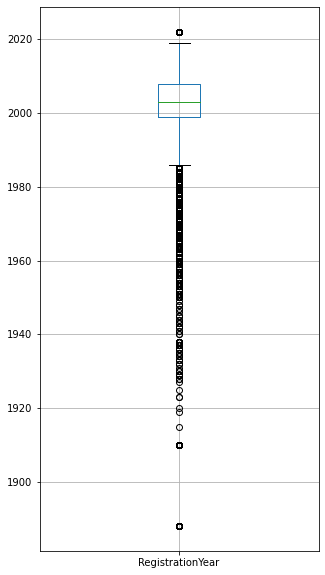

In [22]:
frame.boxplot('RegistrationYear', grid=True, figsize=(5, 10));

#### Обработка столбца Price

В столбце минимум равен нулю, также расчитано высокое значение стандартного отклонения для целевого признака.  
Оценим распределение значений на графике:

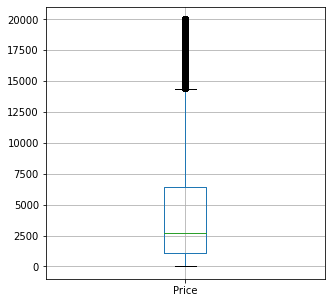

In [23]:
frame.boxplot('Price', grid=True, figsize=(5, 5));

Оценим распределение первой четверти значений (0-25%):

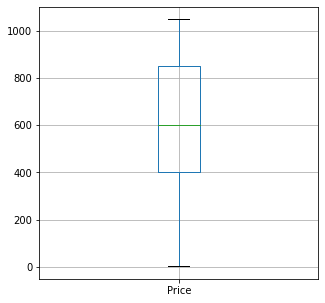

In [24]:
frame.loc[(frame['Price'] > frame['Price'].quantile(0)) 
         & (frame['Price'] < frame['Price'].quantile(0.25))].boxplot('Price', grid=True, figsize=(5, 5));

Вычислим первый квартиль для первой четверти значений (0-25%), он будет нашей первой границей при фильтрации значений цены:

In [25]:
q_min = frame['Price'].loc[(frame['Price'] > frame['Price'].quantile(0)) 
         & (frame['Price'] < frame['Price'].quantile(0.25))].quantile(0.25)
print(q_min)

400.0


Расчитаем верхнюю границу значений для столбца "Price" таблицы и отфильтруем значения:

In [26]:
#расчет МКР
q25 = frame['Price'].quantile(0.25)
q75 = frame['Price'].quantile(0.75)
#расчет усов
first_part=q25-1.5*(q75-q25)
second_part=q75+1.5*(q75-q25)
# фильтрация таблицы: для минимума первый квартиль для первой четверти значений, для максимума - ус максимума
frame = frame.loc[frame['Price'] >= q_min]
frame = frame.loc[frame['Price'] <= second_part]

Оценим распределение значений столбца "Price":

In [27]:
frame['Price'].describe()

count    305366.000000
mean       4061.771527
std        3447.362649
min         400.000000
25%        1300.000000
50%        2899.000000
75%        5990.000000
max       14400.000000
Name: Price, dtype: float64

In [28]:
print('Всего из таблицы удалено строк:', frame_with_date.shape[0]-frame.shape[0])

Всего из таблицы удалено строк: 48998


### Вывод

* Пропуски  в категорийных признаках заполнялись модой;
* Дубликаты объектов: было найдено 5 шт - удалены;
* Проверена корреляция
* Данные были очищены от выбросов и аномальных значений. Всего из таблицы удалено строк: 48998

## Обучение моделей

### Разделение выборок

Создадим дополнительно две выборки. Таким образом, у нас будет три выборки для трех различных моделей обучения.

In [29]:
#закодируем техникой One Hot Encoder 
frame_ohe = frame.copy()
frame_ohe = pd.get_dummies(frame_ohe)

#создадим словарь категориальных признаков для LightGBM
frame_light = frame.copy()
frame_light = frame_light.astype({"VehicleType":'category',
                                  "Gearbox":'category',
                                  "Model":'category',
                                  "FuelType":'category',
                                  "Brand":'category',
                                  "NotRepaired":'category'})

Разделим данные на выборки в соотношении 3 к 1:

In [30]:
(trainX,
 testX,
 trainY,
 testY) = train_test_split(frame_ohe.drop('Price', axis = 1),
                                             frame_ohe['Price'],
                                             test_size = 0.25,
                                             random_state = 42)

(trainX_wo_ohe,
 testX_wo_ohe,
 trainY_wo_ohe,
 testY_wo_ohe) = train_test_split(frame.drop('Price', axis = 1),
                                             frame['Price'],
                                             test_size = 0.25,
                                             random_state = 42)
(trainX_wo_ohe_light,
 testX_wo_ohe_light,
 trainY_wo_ohe_light,
 testY_wo_ohe_light) = train_test_split(frame_light.drop('Price', axis = 1),
                                             frame_light['Price'],
                                             test_size = 0.25,
                                             random_state = 42)

### Обучение CatBoost

In [ ]:
%%time
# catboost с указанием категорий
catboost = CatBoostRegressor(loss_function='RMSE')
parameters_cat = {'depth':[9,10], 'learning_rate':np.arange(0.1,0.3,0.1), 'iterations':[400]}
catboost_grid = catboost.grid_search(parameters_cat,
            Pool(trainX_wo_ohe, trainY_wo_ohe, cat_features=["VehicleType","Gearbox",
                                                             "Model","FuelType",
                                                             "Brand","NotRepaired"]),
            cv=3,
            verbose=True, #100 почему-то не работает, показывает так же
            plot=False)

0:	learn: 4874.9295824	test: 4868.0534392	best: 4868.0534392 (0)	total: 438ms	remaining: 2m 54s
1:	learn: 4476.8337798	test: 4469.5174720	best: 4469.5174720 (1)	total: 733ms	remaining: 2m 25s
2:	learn: 4117.5571547	test: 4110.3027417	best: 4110.3027417 (2)	total: 1.03s	remaining: 2m 16s
3:	learn: 3800.9540375	test: 3793.4164061	best: 3793.4164061 (3)	total: 1.33s	remaining: 2m 12s
4:	learn: 3519.0171743	test: 3510.5113068	best: 3510.5113068 (4)	total: 1.75s	remaining: 2m 18s
5:	learn: 3272.5259933	test: 3263.1255948	best: 3263.1255948 (5)	total: 2.07s	remaining: 2m 16s
6:	learn: 3055.8834447	test: 3046.2109352	best: 3046.2109352 (6)	total: 2.38s	remaining: 2m 13s
7:	learn: 2863.0510621	test: 2853.1395179	best: 2853.1395179 (7)	total: 2.69s	remaining: 2m 11s
8:	learn: 2692.4683120	test: 2681.9571990	best: 2681.9571990 (8)	total: 2.97s	remaining: 2m 8s
9:	learn: 2542.2692675	test: 2531.6850890	best: 2531.6850890 (9)	total: 3.32s	remaining: 2m 9s
10:	learn: 2413.5133283	test: 2402.2879279

In [ ]:
#CPU times: user 57min 34s, sys: 38.9 s, total: 58min 13s
#Wall time: 58min 45s

Лучшие параметры:

In [ ]:
catboost_grid['params']

Проверим время обучения с найденными параметрами для каждой модели:
{'depth': 10, 'learning_rate': 0.1}

In [ ]:
%%time
final_cat = CatBoostRegressor(depth=catboost_grid['params']['depth'], 
                              learning_rate=catboost_grid['params']['learning_rate'],
                              loss_function='RMSE', verbose=100)
final_cat.fit(Pool(trainX_wo_ohe,trainY_wo_ohe,
                   cat_features=['VehicleType','Gearbox','Model','FuelType','Brand','NotRepaired']))

In [ ]:
# 1я итерация
#CPU times: user 5min 55s, sys: 937 ms, total: 5min 56s
#Wall time: 5min 59s

# 2я итерация
#CPU times: user 15min 33s, sys: 2.96 s, total: 15min 36s
#Wall time: 15min 45s

In [ ]:
%%time
print("CatBoost RMSE:",mean_squared_error(trainY_wo_ohe,final_cat.predict(trainX_wo_ohe),squared=False))

### Обучение RandomForest

In [ ]:
%%time
# RandomForest
RF = RandomForestRegressor(criterion = "mse",random_state=42,n_estimators = 100,n_jobs=-1)
RF.fit(trainX,trainY)

In [ ]:
# 1я итерация
#CPU times: user 8min 57s, sys: 1.47 s, total: 8min 58s
#Wall time: 9min 4s

# 2я итерация
#CPU times: user 11min 29s, sys: 2.79 s, total: 11min 32s
#Wall time: 11min 40s

In [ ]:
%%time
print("RandomForest RMSE:",mean_squared_error(trainY,RF.predict(trainX),squared=False))

### Обучение LightGBM

In [ ]:
%%time
# LightGBM
lgb_train = lgb.Dataset(trainX_wo_ohe_light, trainY_wo_ohe_light)
lgb_test = lgb.Dataset(testX_wo_ohe_light, testY_wo_ohe_light, reference=lgb_train)
parameters_light = {'metric': 'l2', 'max_depth':10,"random_state": 42,"learning_rate":0.1}
light = lgb.train(parameters_light,
                lgb_train,
                num_boost_round=1000,
                valid_sets=[lgb_train, lgb_test],
                verbose_eval=100)

In [ ]:
# 1я итерация
#CPU times: user 10min 23s, sys: 3.47 s, total: 10min 26s
#Wall time: 10min 32s

# 2я итерация
#CPU times: user 1min 16s, sys: 413 ms, total: 1min 16s
#Wall time: 1min 17s

In [ ]:
%%time
print("LightGBM RMSE:",(mean_squared_error(trainY_wo_ohe_light,light.predict(trainX_wo_ohe_light),squared=False)))

### Вывод

Исходя из данных пунтов 2.2 - 2.4, получены следующие результаты:  
1) CatBoost RMSE: 1124.171560509659, CPU times: user 4.91 s, sys: 3.85 ms, total: 4.91 s, Wall time: 5.21 s  
2) RandomForest RMSE: 659.4039260147264, CPU times: user 15.6 s, sys: 241 ms, total: 15.8 s, Wall time: 15.9 s  
3) LightGBM RMSE: 1184.064478091607, CPU times: user 28.9 s, sys: 27.4 ms, total: 28.9 s, Wall time: 28.9 s

Для дальнейшей работы предлагается использовать модель CatBoost, как самую быструю по критерию времени предсказаний и приемлимую по качеству предсказаний

### Работа моделей на тестовой выборке

In [ ]:
%%time
print("CatBoost:",mean_squared_error(testY,final_cat.predict(testX_wo_ohe),squared=False))

In [ ]:
%%time
print("RandomForest:",mean_squared_error(testY,RF.predict(testX),squared=False))

In [ ]:
%%time
print("LightGBM:",(mean_squared_error(testY,light.predict(testX_wo_ohe_light),squared=False)))

## Анализ моделей

В задании указано, что решающими факторами при выборе модели являются следующие показатели:  
* Время обучения
* Время предсказания
* Качество предсказаний  

На тренировочной выборке были получены следующие результаты:  
1) CatBoost RMSE: 1124.171560509659, CPU times: user 4.91 s, sys: 3.85 ms, total: 4.91 s, Wall time: 5.21 s  
2) RandomForest RMSE: 659.4039260147264, CPU times: user 15.6 s, sys: 241 ms, total: 15.8 s, Wall time: 15.9 s  
3) LightGBM RMSE: 1184.064478091607, CPU times: user 28.9 s, sys: 27.4 ms, total: 28.9 s, Wall time: 28.9 s

Исходя из данных результатов и факторов выбора модели, была выбрана модель CatBoost.  
На тестовой выборке она показала следующие результаты:  
* RMSE: 1314.0592526961445, CPU times: user 1.62 s, sys: 0 ns, total: 1.62 s, Wall time: 1.63 s